In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [62]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [63]:
# Change working directory 
inputpath = '/kaggle/input/insurance'
os.chdir(inputpath)
path = os.getcwd()
print(path)

/kaggle/input/insurance


In [64]:
# Data import with Pandas 
df = pd.read_csv('insurance.csv')

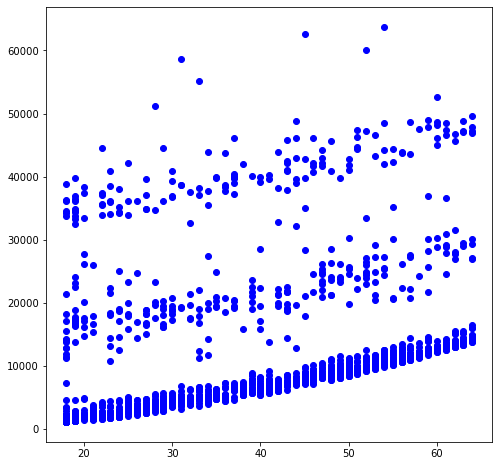

In [65]:
# plotting the data to reveal its structure 
plt.figure(figsize=(8,8)) # instantiate a plot object
plt.plot(df['age'],df['charges'],'bo') # plot the objects,

The above plot immediately reveals that there exists two groups of data (corresponding to smokers and non-smokers that should be separately treated.

In [66]:
smokerdf = df[(df.smoker=='yes') & (df.bmi.between(25,30))] # Subset of data with smoker identity being yes and bmi between 25 and 30 

In [67]:
smokerdf

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
11,62,female,26.290,0,yes,southeast,27808.72510
52,48,male,28.000,1,yes,southwest,23568.27200
92,59,male,29.830,3,yes,northeast,30184.93670
103,61,female,29.920,3,yes,southeast,30942.19180
...,...,...,...,...,...,...,...
1281,47,female,27.645,2,yes,northwest,24535.69855
1303,43,male,27.800,0,yes,southwest,37829.72420
1307,32,male,28.120,4,yes,northwest,21472.47880
1321,62,male,26.695,0,yes,northeast,28101.33305


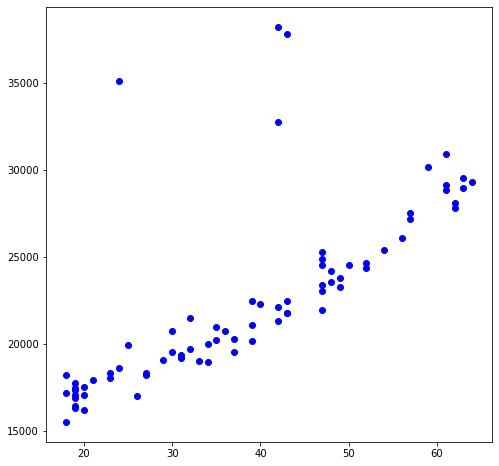

In [68]:
# plotting the data to reveal its structure 
plt.figure(figsize=(8,8)) # instantiate a plot object
plt.plot(smokerdf['age'],smokerdf['charges'],'bo') # plot the objects,

Clearly this subset of the original dataset becomes amenable to Bayesian linear regression

In [69]:
# Create design matrix and response vectors 
smokerdf['Intercept'] = 1 # create a vector of all 1
X = smokerdf.loc[:,['Intercept','age']] # this is the design matrix 
y = smokerdf.loc[:,'charges']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Ordinary Least Sqaure Regression

In [70]:
# Ordinary Least Sqaure Regression 
linear_regression = LinearRegression()
linear_regression.fit(np.array(X.age).reshape(-1,1),y)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])

Intercept from library: 12394.629274103134
Slope from library: 263.84722109138147


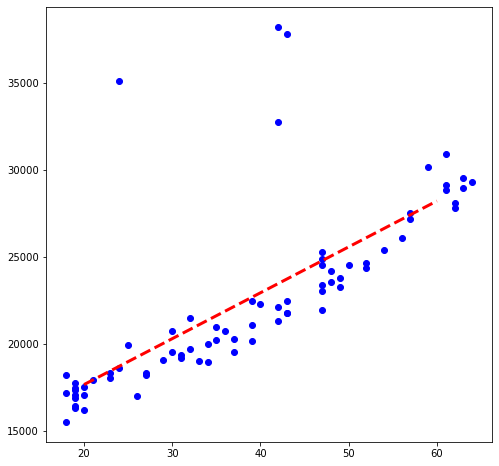

In [71]:
# plotting the data to reveal its structure, plus to OLS line 
xs = np.linspace(20,60,1000)
ys = linear_regression.intercept_ + linear_regression.coef_[0]*xs
plt.figure(figsize=(8,8)) # instantiate a plot object
plt.plot(smokerdf['age'],smokerdf['charges'],'bo') # plot the objects, 
plt.plot(xs,ys,'r--',label='OLS Fit',linewidth=3)

## Bayesian Linear Regression

In [82]:
x = X.loc[:,'age']
y = y
data = {'x':x,'y':y}

In [121]:

# Running bayesian simple linear regression with pm 
with pm.Model() as model:
# Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'age'].values
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values/1000) #Note that y has been scaled down to prevent the overflow errors 
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(10000, step)

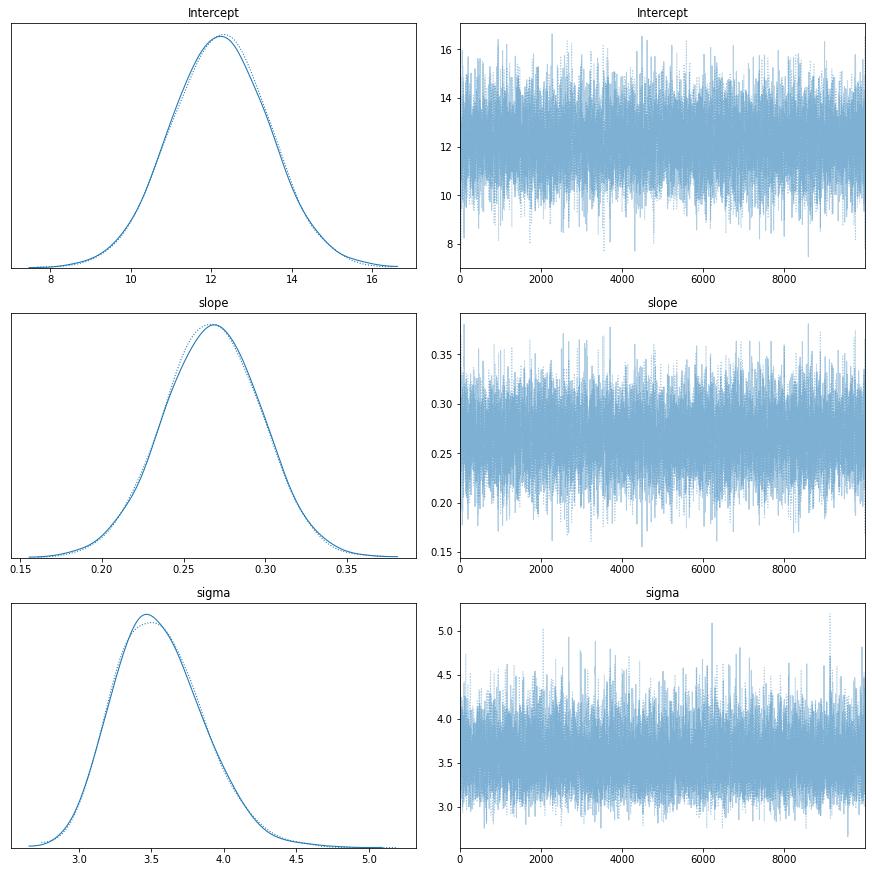

In [122]:
pm.traceplot(linear_trace, figsize = (12, 12));


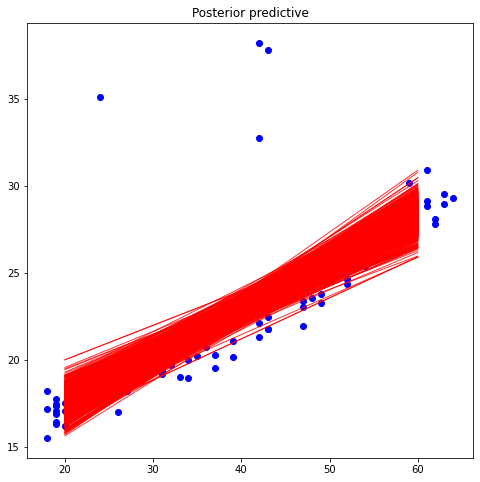

In [125]:
# plotting the data to reveal its structure, plus the bayesian regression lines, a limited of them 
xs = np.linspace(20,60,1000)
ys = (linear_regression.intercept_ + linear_regression.coef_[0]*xs)/1000
plt.figure(figsize=(8,8)) # instantiate a plot object
plt.plot(smokerdf['age'],smokerdf['charges']/1000,'bo') # plot the objects, 
pm.plot_posterior_predictive_glm(linear_trace, samples = 50, eval=np.linspace(20, 60, 1000), linewidth = 1, color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);